In [1]:
import pandas as pd

# Load raw CSV without setting headers
df_raw = pd.read_csv("financial_data.csv", header=None)

# Extract column names from row 0
column_names = df_raw.iloc[0].tolist()
column_names[0] = "Date"  # Fix the first column name

# Extract the actual financial data from row 3 onwards
df_financial = df_raw.iloc[3:].copy()

# Assign proper column names
df_financial.columns = column_names

# Convert "Date" column to datetime
df_financial["Date"] = pd.to_datetime(df_financial["Date"], errors="coerce")

# Ensure numerical columns are properly converted
num_cols = df_financial.columns[1:]  # Exclude "Date"
df_financial[num_cols] = df_financial[num_cols].apply(pd.to_numeric, errors="coerce")

# Sort by date
df_financial = df_financial.sort_values("Date").reset_index(drop=True)

# Save the cleaned financial data
df_financial.to_csv("processed_financial_data.csv", index=False)

print("Financial data")
print(df_financial.head())



Financial data
        Date      Close       High        Low       Open    Volume
0 2019-01-02  82.916229  83.308644  80.102542  80.110887  15670900
1 2019-01-03  81.737831  83.236062  81.384317  83.025637  16286400
2 2019-01-04  84.751122  84.953129  82.722613  83.421229  16935200
3 2019-01-07  84.810051  85.407660  83.926260  84.532287  15430700
4 2019-01-08  84.650131  85.702261  83.791596  85.542335  13578800


In [9]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29482 sha256=a3e813f7bc8a3446a7350a8420731c21eace344ad2446fb1371fbee69c433eac
  Stored in directory: /Users/yuuvjauhari/Library/Caches/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
'''import pandas as pd
import ta  # Technical Analysis Library
import numpy as np

# Load the cleaned financial data
df_financial = pd.read_csv("processed_financial_data.csv", parse_dates=["Date"])

# Ensure data is sorted properly
df_financial = df_financial.sort_values("Date").reset_index(drop=True)

### === ADDING TECHNICAL INDICATORS === ###

# Moving Averages
df_financial["SMA_20"] = ta.trend.sma_indicator(df_financial["Close"], window=20)
df_financial["SMA_50"] = ta.trend.sma_indicator(df_financial["Close"], window=50)
df_financial["EMA_20"] = ta.trend.ema_indicator(df_financial["Close"], window=20)

# Relative Strength Index (RSI)
df_financial["RSI_14"] = ta.momentum.rsi(df_financial["Close"], window=14)

# Moving Average Convergence Divergence (MACD)
df_financial["MACD"] = ta.trend.macd(df_financial["Close"])

# Bollinger Bands
bb = ta.volatility.BollingerBands(df_financial["Close"], window=20)
df_financial["BB_High"] = bb.bollinger_hband()
df_financial["BB_Low"] = bb.bollinger_lband()

# Average True Range (ATR) for Volatility
df_financial["ATR"] = ta.volatility.average_true_range(df_financial["High"], df_financial["Low"], df_financial["Close"], window=14)

# Rate of Change (ROC) for Trend Strength
df_financial["ROC_10"] = ta.momentum.roc(df_financial["Close"], window=10)

# Log Returns (daily)
df_financial["Log_Returns"] = df_financial["Close"].pct_change().apply(lambda x: np.log(1+x))

# Cumulative Returns (to measure total performance)
df_financial["Cumulative_Returns"] = (1 + df_financial["Log_Returns"]).cumprod()

# Drop rows with NaN values generated by indicators
df_financial.dropna(inplace=True)

# Save updated financial data
df_financial.to_csv("enhanced_financial_data.csv", index=False)

print("Technical indicators added")'''


Technical indicators added


In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import QuantileRegressor
from sklearn.preprocessing import StandardScaler

# Load enhanced financial data
df_financial = pd.read_csv("processed_financial_data.csv", parse_dates=["Date"])

# Define predictors (all technical indicators) and target (Close price)
feature_cols = ["Open", "High", "Low", "Volume"]

X = df_financial[feature_cols]
y = df_financial["Close"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define quantiles for prediction (10%, 50%, 90%)
quantiles = [0.1, 0.5, 0.9]

# Dictionary to store quantile predictions
quantile_preds = {}

for q in quantiles:
    q_model = QuantileRegressor(quantile=q, alpha=0)  # alpha=0 means no regularization
    q_model.fit(X_scaled, y)
    quantile_preds[f"Quantile_{int(q * 100)}"] = q_model.predict(X_scaled)

# Convert predictions to DataFrame and merge with the original dataset
df_quantiles = pd.DataFrame(quantile_preds)
df_financial = pd.concat([df_financial, df_quantiles], axis=1)

# Save updated dataset
df_financial.to_csv("enhanced_financial_data.csv", index=False)

print("Quantile regression features added")


Quantile regression features added


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load enhanced dataset
df = pd.read_csv("enhanced_financial_data.csv", parse_dates=["Date"])

# Define input features (excluding Date & Target)
feature_cols = [col for col in df.columns if col not in ["Date", "Close"]]

# Convert to numpy arrays
X = df[feature_cols].values
y = df["Close"].values  # Target

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Data Prepared: {X_train.shape[0]} train samples, {X_test.shape[0]} test samples")


Data Prepared: 1228 train samples, 308 test samples


In [17]:
# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=2000,  # Number of trees
    max_depth=100,      # Limit tree depth for better generalization
    random_state=42,
    n_jobs=-1  # Use all CPU cores for faster training
)

# Train the model
rf_model.fit(X_train, y_train)

print("Random Forest Model Trained!")


Random Forest Model Trained!


In [18]:
# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Compute Metrics
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"\nRandom Forest Performance:")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.4f}")


Random Forest Performance:
MSE: 3029.18
R² Score: -2.3635


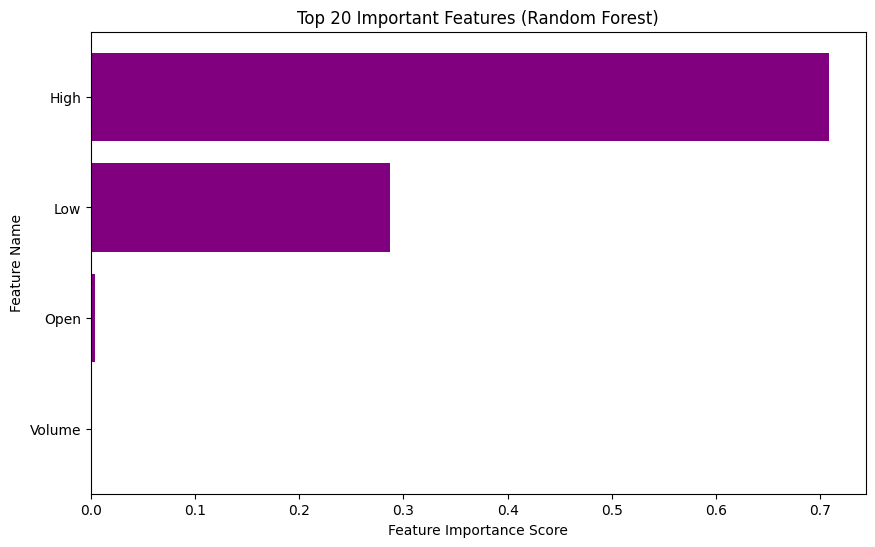

In [19]:
# Get feature importance from the trained model
feature_importance = rf_model.feature_importances_

# Create DataFrame for sorting
importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False).head(20)  # Show top 20

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="purple")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()


In [15]:
import pandas as pd
import re

# Load raw news dataset
df_news_raw = pd.read_csv("entity_news_paged.csv")

# Extract only the author's name from the 'author' column
def extract_author_name(author_text):
    match = re.search(r"'name': '([^']+)'", author_text)
    return match.group(1) if match else "Unknown"

df_news_raw["author"] = df_news_raw["author"].apply(extract_author_name)

# Convert published_at to date format (remove time)
df_news_raw["published_at"] = pd.to_datetime(df_news_raw["published_at"]).dt.date

# Drop 'url' column
df_news_raw.drop(columns=["url"], inplace=True)

# Save cleaned dataset
df_news_raw.to_csv("cleaned_news_data.csv", index=False)

print(f"News data cleaned Shape: {df_news_raw.shape}")


News data cleaned Shape: (5851, 5)
